# Interpreting what convnets learn

If you are in colab, you may upload `convnet_from_scratch_with_augmentation.keras` from `..\convnet_from_scratch_with_augmentation.keras`, otherwise put under this directory.

In [15]:
def is_colab():
    try:
        import google.colab
        return True
    except ImportError:
        return False

if is_colab():
    from google.colab import files
    files.upload()

Saving convnet_from_scratch_with_augmentation.keras to convnet_from_scratch_with_augmentation (1).keras


In [23]:
!unzip -l "convnet_from_scratch_with_augmentation.keras"

Archive:  convnet_from_scratch_with_augmentation.keras
  End-of-central-directory signature not found.  Either this file is not
  a zipfile, or it constitutes one disk of a multi-part archive.  In the
  latter case the central directory and zipfile comment will be found on
  the last disk(s) of this archive.
unzip:  cannot find zipfile directory in one of convnet_from_scratch_with_augmentation.keras or
        convnet_from_scratch_with_augmentation.keras.zip, and cannot find convnet_from_scratch_with_augmentation.keras.ZIP, period.


In [17]:
import os
print(os.listdir())

['.config', 'convnet_from_scratch_with_augmentation (1).keras', 'convnet_from_scratch_with_augmentation.keras', 'sample_data']


In [24]:
import keras

model = keras.saving.load_model("convnet_from_scratch_with_augmentation (1).keras")

ValueError: File not found: filepath=convnet_from_scratch_with_augmentation (1).keras. Please ensure the file is an accessible `.keras` zip file.

In [ ]:
model.summary(line_length=80)

NameError: name 'model' is not defined

In [ ]:
import numpy as np

img_path = keras.utils.get_file(
    fname="cat.jpg", origin="https://img-datasets.s3.amazonaws.com/cat.jpg"
)

def get_img_array(img_path, target_size):
    img = keras.utils.load_img(img_path, target_size=target_size)
    array = keras.utils.img_to_array(img)
    array = np.expand_dims(array, axis=0)
    return array

img_tensor = get_img_array(img_path, target_size=(180, 180))

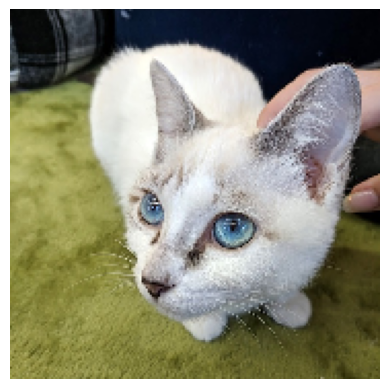

In [ ]:
import matplotlib.pyplot as plt

plt.axis("off")
plt.imshow(img_tensor[0].astype("uint8"))
plt.show()

In [ ]:
from keras import layers

layer_outputs = []
layer_name = []
for layer in model.layers:
    if isinstance(layer, (layers.Conv2D, layers.MaxPool2D)):
        layer_outputs.append(layer.output)
        layer_name.append(layer.name)
activation_model = keras.Model(inputs=model.input, )

NameError: name 'model' is not defined